# **DATA SCIENCE**
**Project Titel : SP1 Transcription Factor DNA Binding Site Prediction**

Amin Sharifi' s Final Project



Mentor : Shabnam Sadeghi

**Introduction:**
Transcription Factors are proteins that bind to specific sequence motifs on the DNA in order to regulate DNA activity. SP1 transcription factor binds to GC (Nucleobase: Building blocks of DNA) rich motifs.

**Question:**
Given the input data, is it possible to predict the nucleotide sequences as SP1 factor binding/non-binding site based on the presence/absence of motifs present in nucleotides ?

In [ ]:
 #Importing the essential libraries
import pandas as pd
import numpy as np

#Importing the dataset
df = pd.read_csv('Raw_data.csv')

In [ ]:
#PART 1: Exploring the Data

#Checking the head of the dataset
df.head()

,sequence,label
0,ATCCGTTTCCGGGT,binding site
1,GGCTTTTCGGGCTA,binding site
2,CCCTGCTCTGCCTG,binding site
3,CGCTCCCCGGCGGC,binding site
4,GGGCGGGGCCTGGG,binding site


In [ ]:
#Checking the shape of the data
df.shape

(2400, 2)

In [ ]:
#Checking the characteristics of the data frame and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  2400 non-null   object
 1   label     2400 non-null   object
dtypes: object(2)
memory usage: 37.6+ KB


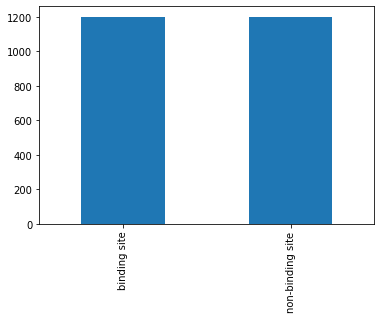

In [ ]:
#Check if the dataset is balanced
df.value_counts('label')
df['label'].value_counts().sort_index().plot.bar()

In [ ]:
#Check if all the sequences have length of 14
seqLen =[len(s) for s in df['sequence']]
set(seqLen)

{14}

In [ ]:
#PART 2: Create N-Gram(Fragmentize the sequence to characters with length of N) from the DNA sequences in order to prepare the data set for modeling
#Here we use Bag of Words model using count vectorizer

#Import the library
from sklearn.feature_extraction.text import CountVectorizer
seq_texts = df['sequence']

In [29]:
#Create 2-5 mers from the Sequences
cv = CountVectorizer(analyzer='char',ngram_range=(2,5),min_df=0.10,max_df=0.8)
X = cv.fit_transform(seq_texts)

print(X.shape)
X

(2400, 84)


<2400x84 sparse matrix of type '<class 'numpy.int64'>'
	with 45526 stored elements in Compressed Sparse Row format>

In [30]:
#Transform output (label) to a binary output
df[ "label_binary" ] = df[ "label" ].map({ 'binding site' : 1,'non-binding site' : 0 } )
y = df[ "label_binary"]#Checking the label type after converting to binary value

df.dtypes

sequence        object
label           object
label_binary     int64
dtype: object

In [31]:
#Sequences are converted to vecotrs, which consist of number of occurence for each 2-5-mers
#Check how the vectors look like
X_array = X.toarray()
X_array

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 3],
       [1, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
#We want to access the actual nucleobase sequence fragments of the 2-5-mer
feature_names = cv.get_feature_names()

In [33]:
#PART 3: Spliting the data set
#We will devide the data set to three parts. Train (≈60%), validation(≈20%) and test(≈20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [34]:
#Sanity check: The ratio of each group to the total
print('Train:',X_train.shape[0]/df.shape[0])
print('Validation:',X_val.shape[0]/df.shape[0])
print('Validation:',X_test.shape[0]/df.shape[0])

Train: 0.64
Validation: 0.16
Validation: 0.2


In [35]:
#Check the shape of the Train group
X_train.shape

(1536, 84)

In [36]:
#PART 4: Creating the Model
#For our data set we will use Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 , random_state=43)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)

In [37]:
#We trained the model and we want check the accuracy of the model's prediction
y_pred = clf.predict(X_val)
from sklearn import metrics

In [38]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.8854166666666666


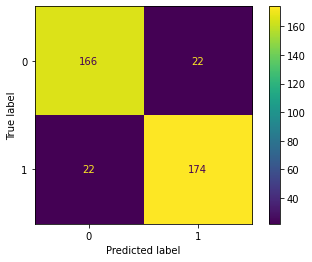

In [39]:
#PART 5: Investigating the performance of the classification model by three methods:
# 1) Confusion Matrix   2) Roc Curve   3)Classification Report

#1) Confusion Matrix : 
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

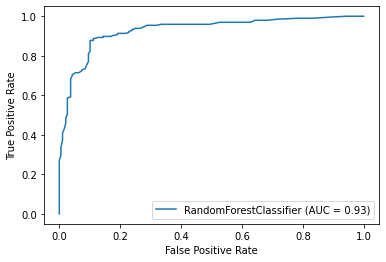

In [40]:
#2) ROC (receiver operating characteristic) Curve:
#We can use different thresholds for classification. ROC curve summarizes all of the confusion matrices that each threshold produced
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf, X_val, y_val)


In [41]:
#3) Classification Report:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88       188
           1       0.89      0.89      0.89       196

    accuracy                           0.89       384
   macro avg       0.89      0.89      0.89       384
weighted avg       0.89      0.89      0.89       384



In [42]:
#PART 6: Feature Importance
#We want to investigate which 2-5-mers (sequence fragments) play a more important role in our model 
feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feature_imp

29    0.124284
46    0.069744
49    0.062541
31    0.045398
15    0.043823
        ...   
67    0.002722
20    0.002370
16    0.002004
55    0.001928
60    0.001565
Length: 84, dtype: float64

In [43]:
#Instead of the indexes we would like to see the actual sequence fragments
#We need to make a data frame where each fragments is assigned to it's corresponding feature importance
dic_feature_imp = {'feature_name':np.array(feature_names)[feature_imp.index], 'feature_imp': feature_imp} 
df_feature_imp = pd.DataFrame(dic_feature_imp)
df_feature_imp

,feature_name,feature_imp
29,cg,0.124284
46,gcg,0.069744
49,gg,0.062541
31,cgg,0.045398
15,at,0.043823
...,...,...
67,taa,0.002722
20,caa,0.002370
16,ata,0.002004
55,ggcgg,0.001928


In [67]:
#Prepare the data frame for ploting the feature importance 
#Importing the libraries 
import seaborn as sns 
import matplotlib.pyplot as plt

#Creating a data frame with the N-Gram occurences and the sequence classes
df_plot = pd.DataFrame(X_train.toarray(), columns = feature_names)

#Regarding blox plot visual limitations we can not plot all the feature importances
#We will use the 20 most important features for observation
nGramSum = df_plot.sum()
nGramSum = nGramSum.sort_values( ascending=False)
nGramTop = pd.DataFrame(df_plot[nGramSum.index[:20]])
nGramTop['class'] = y_train.values

#Check the new data frame
nGramTop


,gg,gc,ag,cc,cg,ga,tg,tt,aa,ct,ca,ggg,tc,at,gt,ac,ta,ggc,gcg,cgg,class
0,2,0,0,1,2,1,0,1,0,0,1,0,2,0,2,1,0,0,0,1,1
1,1,0,3,0,0,4,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,2,0,0,2,2,0,0,2,1,0,1,1,1,0,0,0,0,0,0
3,2,3,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,2,1,2,1
4,1,0,1,0,2,1,0,0,2,0,2,0,1,0,1,2,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0,3,0,0,3,0,0,0,0,3,1,0,2,0,0,1,0,0,1,0,1
1532,0,0,0,0,0,0,0,4,1,0,1,0,0,3,0,1,3,0,0,0,0
1533,2,2,3,0,0,1,1,0,0,0,2,0,0,0,2,0,0,1,0,0,0
1534,3,2,2,1,1,0,1,0,1,0,1,2,0,0,1,0,0,1,0,0,1


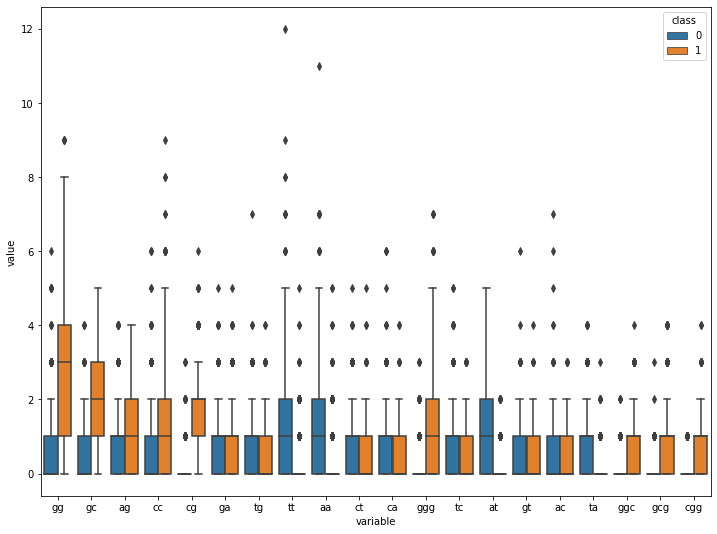

In [72]:
#We can continue now with melting the data and ploting it
meltNGram = pd.melt(nGramTop, id_vars='class')

#Ploting the data
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(x='variable', y='value', hue='class', data=meltNGram)

SP1 Transcription factors bind to GC rich motifs. Results from the blox plot also indicates that binding sites have higher occurence of G or C N-mers. Therefore our model is efficiently predicting our binding sites.

In [74]:
#PART 7: Applying the model to Test group
#The Test group is the last fraction of the data frame to apply the model and is a representation of our model effeciency
y_pred_test = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))

Accuracy: 0.8708333333333333


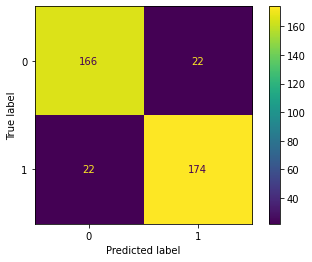

In [75]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')